# Cross Validation
This notebook describes how to do cross validation with simulation models.

Cross validation is used when there are limited experimental data. We want to use these data for two purposes:
* Estimating parameter
* Assessing the accuracy of the model after parameters have been estimated

In [1]:
# First code cell in a notebook contains all installs
if False:
    !apt-get install libncurses5
    !pip install -q tellurium==2.2.8
    !pip install lmfit

# Preliminaries

In [2]:
%matplotlib inline
import collections
import tellurium as te
import lmfit
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

In [3]:
MODEL = """
     A -> B; k1*A
     B -> C; k2*B

     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""

# Helpers

In [4]:
# Experimental conditions
SIMTIME = 30
NOISE_STD = 0.5
NUM_POINT = 300

In [5]:
def runSimulation(sim_time, num_point, parameters=None, roadrunner=None,
                  model=None):
    """
    Runs the simulation model for the parameters.
    :param int sim_time: time to run the simulation
    :param int num_point: number of timepoints simulated
    :param lmfit.Parameters parameters:
    :param tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner road_runner:
    :param str model:
    :return named_array:
    """
    if roadrunner is None:
        roadrunner = te.loada(model)
    else:
        roadrunner.reset()
    if parameters is not None:
        parameter_dict = parameters.valuesdict()
        # Set the simulation constants for all parameters
        for constant in parameter_dict.keys():
            roadrunner[constant] = parameter_dict[constant]
            #stmt = "roadrunner.%s = parameter_dict['%s']" % (constant, constant)
            #exec(stmt)
    return roadrunner.simulate(0, sim_time, num_point)

# Tests
parameters = lmfit.Parameters()
parameters.add("k1", value=1, min=0, max=100)
parameters.add("k2", value=2, min=0, max=100)
data = runSimulation(SIMTIME, NUM_POINT, parameters=parameters, model=MODEL)
assert(np.shape(data) == (NUM_POINT, 4))
print("OK!")

OK!


# Create synthetic observational data

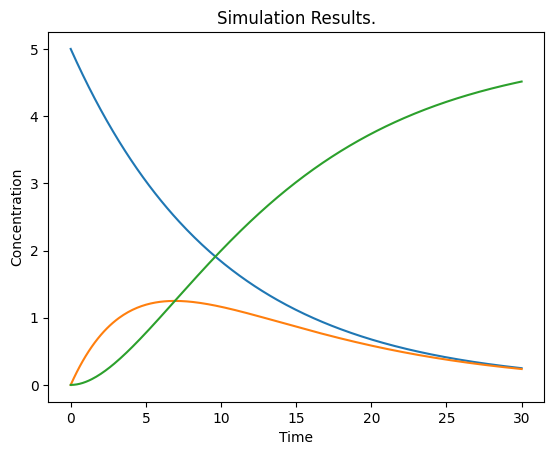

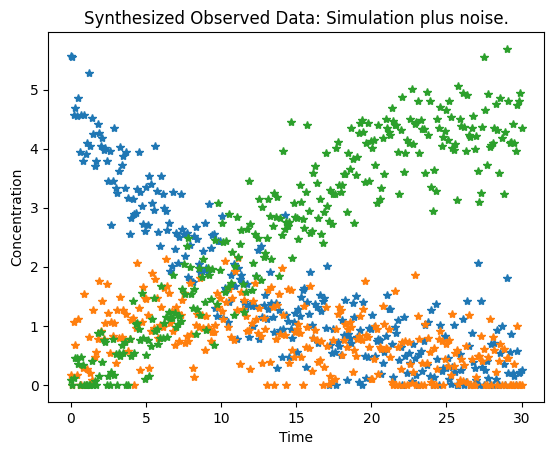

In [6]:
# Create the experimental data. We refer to these as the observations
data = runSimulation(SIMTIME, NUM_POINT, model=MODEL)
num_cols = len(data.colnames) - 1

# Create some 'experimental' data
x_data = data[:, 0]  # Times
obs_data = data.copy()
obs_data = obs_data[:,1:]   # Values of chemical species

for i in range (NUM_POINT):
    for j in range(num_cols):
        obs_data[i, j] = max(obs_data[i, j] + np.random.normal(0, NOISE_STD, 1), 0)


# Plot the simulation data.
plt.plot (x_data, data[:, 1:])
plt.title("Simulation Results.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

# Plot the observed data.
plt.plot (x_data, obs_data, marker='*', linestyle='None')
plt.title("Synthesized Observed Data: Simulation plus noise.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()


# Cross Validation

## Step 1: Generate folds

In [7]:
# Generates indices of training and test data
# by alternating between folds
def foldGenerator(num_point, num_fold):
    """
    Calculates training and test indices for rotating folds.

    Args:
        num_point: int (total number of points)
        num_fold: int (number of folds)
    Returns:
        list-tuple(list-int)
            list of tuples
                tuple[0]: training indices
                tuple[1]: test indices
    """
    indices = range(num_point)
    for remainder in range(num_fold):
       test_indices = []
       for idx in indices:
         if idx % num_fold == remainder:
           test_indices.append(idx)
       train_indices = np.array(
           list(set(indices).difference(test_indices)))
       test_indices = np.array(test_indices)
       yield train_indices, test_indices

# Test
num_point = 10
num_fold = 5
fold_results = list(foldGenerator(num_point, num_fold))
assert(len(fold_results) == num_fold)
assert(len(fold_results[0])== 10//num_fold)

## Step 2: Calculate Parameter Estimates for Each Fold

In [8]:
# Define a 'container' for the results for a fold
FoldResult = collections.namedtuple("FoldResult", "parameters, rsq")

In [9]:
# Create the results
def calculateFoldResults(model, parameter_names, obs_data, num_fold):
    """
    Estimates parameters for each fold and calculates its R2

    Args:
        model: Antimony model
        parameter_names: list-str (names of parameters to estimate)
        obs_data: Observational data
        num_fold: number of folds
    Returns:
        pd.DataFrame
            index: fold
            columns: parameter, rsq
    """
    roadrunner = te.loada(model)
    def calcResiduals(parameters, indices):
        """
        Runs a simulation with the specified parameters and calculates residuals
        for the train_indices.
        """
        sim_data = runSimulation(SIMTIME, len(obs_data), roadrunner=roadrunner,
                                 parameters=parameters)
        sim_data = sim_data[:, 1:]  # Skip time
        residuals = obs_data[indices, :] - sim_data[indices, :]
        return residuals.flatten()
    #
    # Estimate the parameters for each fold
    fold_results = []
    fold_generator = foldGenerator(len(obs_data), num_fold)
    # Construct the result container
    result_dct = {n: [] for n in parameter_names}
    result_dct["rsq"] = []
    for train_indices, test_indices in fold_generator:
        # Set the parameters for this fold
        parameters = lmfit.Parameters()
        for name in parameter_names:
            parameters.add(name, value=1, min=0, max=10)
        fitter_result = lmfit.minimize(calcResiduals, parameters, args=(train_indices, ))
        # Calculate the RSQ value for the test indices
        test_predictions = runSimulation(SIMTIME, NUM_POINT, roadrunner=roadrunner,
                                    parameters=fitter_result.params)
        try:
            test_predictions = test_predictions[test_indices, 1:]
        except:
            import pdb; pdb.set_trace()
        test_obs = obs_data[test_indices, :]
        residuals = test_obs.flatten() - test_predictions.flatten()
        rsq = 1 - np.var(residuals)/np.var(test_obs.flatten())
        # Accumulate the results
        result_dct["rsq"].append(rsq)
        values_dct = fitter_result.params.valuesdict()
        for name in parameter_names:
            result_dct[name].append(values_dct[name])
    df = pd.DataFrame(result_dct)
    df.index.name = "fold"
    return df

# Tests
result_df =  calculateFoldResults(MODEL, ["k1", "k2"], obs_data, 3)
for idx in result_df.index:
    assert(np.abs(result_df.loc[idx, "k1"] - 0.1) <= 0.02)
    assert(np.abs(result_df.loc[idx, "k2"] - 0.2) <= 0.02)
print("OK!")

OK!


In [10]:
result_df

,k1,k2,rsq
fold,,,
0,0.098375,0.205701,0.8937683020804819
1,0.098609,0.196574,0.9033733743845747
2,0.098579,0.204792,0.8839470870963904


## Step 3: Evaluate the results

1. Are parameter values consistent?
1. Is $R^2$ close to 1?

# Exercise

Consider MODEL2
1. Generate synthetic observational data for 300 points with a standard deviation of 0.2.
1. Compare the cross validation results for:
    1. 3 folds
    1. 10 folds
    1 30 folds